In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
from tqdm import tqdm

In [3]:
pedestals=pd.read_csv("pedestals.csv", sep=',')
pedestals=pedestals.drop(columns=['pedestal_per_time_sample', 'std_dev', 'mean'])

In [4]:
mips=pd.read_csv("mip.csv", sep=',')
mips=mips.drop(columns=['eta', 'sigma', 'A'])

In [5]:
def choose_bar(df,layer, strip):
    df=df[df["strip"]==strip]
    df=df[df["layer"]==layer]
    return df

In [6]:
def choose_layer(df,layer):
    df=df[df['layer']==layer]
    return df

In [69]:
def drop_empty(df):
    events=[]
    adc_0=[]
    adc_1=[]
    l=[]
    s=[]
    data=[]

    layers=np.arange(1,20)
    strips=np.arange(0,12)
    
    for layer in layers:
        for strip in strips:
            el=choose_bar(df,layer,strip)
            peds=choose_bar(pedestals,layer,strip)
            mip=choose_bar(mips, layer, strip)

            if not peds.empty: # need to check whether the strip exists 
                el=el[el["adc_sum_end0"]>1.2*peds.iloc[0,-1]] # gets rid of bars where there's no data in end0
                el=el[el["adc_sum_end1"]>1.2*peds.iloc[1,-1]] # gets rid of bars where there's no data in end1
                
                el.loc[:,"adc_sum_end0"]-=peds.iloc[0,-1] # subtracting pedestals
                el.loc[:,"adc_sum_end1"]-=peds.iloc[1,-1]
                
                el.loc[:,"adc_sum_end0"]*=(4.66/mip.iloc[0,-1]) # converting to energy
                el.loc[:,"adc_sum_end1"]*=(4.66/mip.iloc[1,-1])
                
                data.extend(el.values.tolist())
    
    df_s=pd.DataFrame(data, columns=['event', 'adc_sum_end0', 'layer', 'strip', 'adc_sum_end1'])
    
    return df_s

In [8]:
def get_event(df, event):
    df=df[df["event"]==event]
    return df

In [48]:
def drop_nonelectron(df, bl_num):
    events=df.event.unique()
    
    # check first layer
    for event in tqdm(events):
        el=get_event(df, event)
        el_1=choose_layer(el, 1)
        if el_1.shape[0]>1:
            df=df[df.event!=event]
    
    # check bl_num number of back layers
        else:
            el_i=el[el['layer']>=20-bl_num]
            if el_i.shape[0]:
                df=df[df.event!=event]
            
    return df

In [49]:
def sum_energy(df):
    events=df.event.unique()
    energy=[]
    for event in events:
        el=get_event(df,event)
        end0=el['adc_sum_end0'].sum()
        end1=el['adc_sum_end1'].sum()
        energy.append(np.average([end0,end1]))
        
    return energy

In [50]:
def gaussian(x, mu, sig,A):
    return (A / (np.sqrt(2.0 * np.pi) * sig) * np.exp(-np.power((x - mu) / sig, 2.0) / 2))

In [51]:
def fit_gaussian(energies):
    values, bin_edge=np.histogram(energies, bins=30)
    bins=(bin_edge[:-1] + bin_edge[1:]) / 2
    
    param, pcov=curve_fit(gaussian, bins, values)#, p0=[350,100,6000])
    perr=np.sqrt(np.diag(pcov))
    
    return param, perr

In [73]:
%%time
electron=pd.read_csv("run_305.csv", sep=',')
electron=electron.drop(columns=['tot_end0', 'toa_end0','tot_end1', 'toa_end1', 'adc_max_end0', 'adc_max_end1',
                                'pf_spill', 'adc_mean_end0', 'adc_mean_end1', 'pf_ticks'])

electron=electron.astype({"adc_sum_end0":float,"adc_sum_end1":float}) 

Wall time: 16.9 s


In [74]:
%%time
electron=drop_empty(electron)

Wall time: 16 s


In [54]:
%%time
electron=drop_nonelectron(electron,7)

100%|███████████████████████████████████████████████████████████████████████████| 45849/45849 [01:53<00:00, 402.25it/s]

Wall time: 1min 54s


In [55]:
%%time
energy_307=sum_energy(electron)

Wall time: 42.9 s


In [56]:
param_307, perr_305=fit_gaussian(energy_307)

In [57]:
xnums=np.linspace(min(energy_307), max(energy_307),1000)

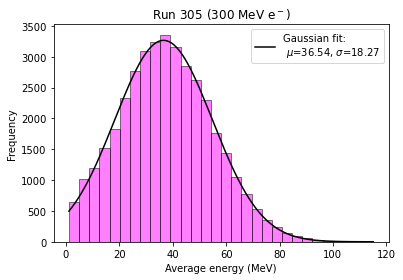

In [58]:
plt.hist(energy_307, bins=30, color='magenta', alpha=0.5, edgecolor='black', zorder=1)
plt.plot(xnums, gaussian(xnums,*param_307), color='black', zorder=2, 
         label=r"Gaussian fit:""\n"" $\mu$="+str(round(param_307[0],2))+", $\sigma$="+str(round(param_307[1],2)))


plt.title(r"Run 305 (300 MeV e$^-$)")
plt.xlabel("Average energy (MeV)")
plt.ylabel("Frequency")
plt.legend(loc='upper right', fontsize=10)
#plt.savefig("run305.png", bbox_inches='tight')
plt.show()